In [1]:
# Import necessary libraries
import os, pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Resize, CenterCrop, Normalize
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # For progress tracking

# Ensure matplotlib plots are displayed inline
%matplotlib inline

/Users/paulanwesha01/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Define mean and standard deviation for normalization
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

# Define data transformations for training and testing datasets
data_transforms = {
                    'train': Compose([RandomResizedCrop(224), RandomHorizontalFlip(), ToTensor(), Normalize(mean, std)]), # train transform
                    'test': Compose([Resize(256), RandomResizedCrop(224), ToTensor(), Normalize(mean, std)])              # test transform
            }       

In [3]:
# Define the directory containing raw image data
raw_data_dir = 'duck_chicken_data'

# Define some hyperparameters
batch_size = 16

# Create datasets using ImageFolder and apply transformations
image_datasets = {x: ImageFolder(os.path.join(raw_data_dir, x), data_transforms[x]) for x in ['train', 'test']}

# Create dataloaders
image_dataloaders = {'train':DataLoader(
                        dataset=image_datasets['train'],
                        batch_size=batch_size,
                        shuffle=True,
                    ),
                     'test':DataLoader(
                        dataset=image_datasets['test'],
                        batch_size=len(image_datasets['test']),
                        shuffle=True,
                    )}

# Calculate dataset sizes
data_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print("Data Sizes:\n", data_sizes)

# Extract class names
class_names = image_datasets['train'].classes
print("\nClass Names:\n", class_names)

Data Sizes:
 {'train': 246, 'test': 24}

Class Names:
 ['chicken', 'duck']


In [4]:
# Extracting the test dataset
X_test, y_test = next(iter(image_dataloaders['test']))

# Print the shape of the test dataset
print(X_test.shape, y_test.shape)

torch.Size([24, 3, 224, 224]) torch.Size([24])


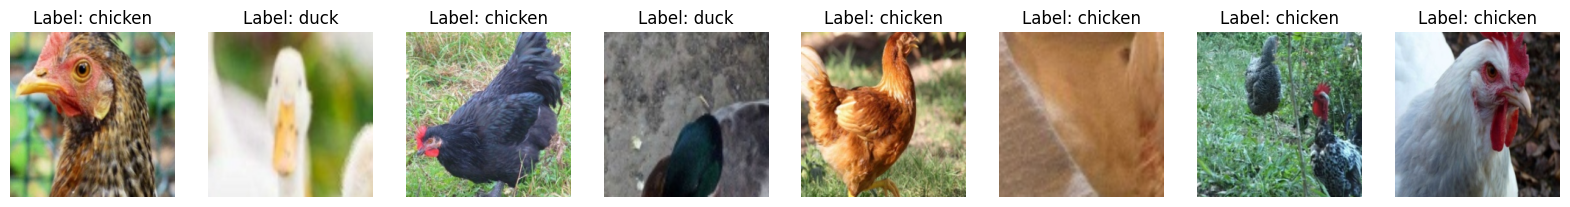

In [5]:
# Define the number of samples to visualize
num_samples = 8

# Create a figure to display the samples
plt.figure(figsize=(20, 4))

# Iterate over the samples
for i in range(num_samples):
    # Plot each sample
    plt.subplot(1, num_samples, i+1)
    
    # Copy the image back to CPU to reshape
    img = X_test[i].cpu()
    
    # Reshape the image and apply inverse normalization
    img = np.transpose(img, (1, 2, 0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    # Display the image with its corresponding label
    plt.imshow(img)
    plt.title("Label: " + class_names[y_test[i]])
    plt.grid(False)
    plt.axis(False)

# Show the visualization
plt.show()

## AlexNet

In [6]:
# Load the pre-trained AlexNet model
model_alexnet = models.alexnet(pretrained=True)

# Replace the classifier with a new fully connected layer
num_features_alexnet = model_alexnet.classifier[6].in_features
model_alexnet.classifier[6] = nn.Linear(num_features_alexnet, len(class_names))

/Users/paulanwesha01/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/paulanwesha01/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# step sizes
print_step = 5
model_save_step = 25

# Set the hyper-parameters
num_epochs_alexnet = 150
learning_rate_alexnet = 0.001

# Define the optimizer
optimizer_alexnet = torch.optim.Adam(model_alexnet.parameters(), lr=learning_rate_alexnet)

# Define the learning rate scheduler
lr_scheduler_alexnet = torch.optim.lr_scheduler.StepLR(optimizer_alexnet, step_size=8, gamma=0.1)

# Store the training loss
train_losses_alexnet = []

# Training loop for AlexNet
for epoch in tqdm(range(num_epochs_alexnet)):
    # Set the model to training mode
    model_alexnet.train()

    # Keep track of the epoch training loss
    epoch_loss_alexnet = 0.0

    # Loop over the training data in batches
    for inputs, labels in image_dataloaders['train']:
        # Zero the parameter gradients
        optimizer_alexnet.zero_grad()

        # Forward pass
        outputs = model_alexnet(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer_alexnet.step()

        # Update the epoch training loss
        epoch_loss_alexnet += loss.item()
    
    # Store the mean epoch loss
    train_losses_alexnet.append(epoch_loss_alexnet/len(image_dataloaders['train']))

    # Print training information every `print_step` epochs
    if (epoch + 1) % print_step == 0:
        print("Epoch {}/{} Training Loss (AlexNet): {:.4f}".format(epoch+1, num_epochs_alexnet, train_losses_alexnet[-1]))
    
    # Save the model weights every `model_save_size` epochs
    if (epoch + 1) % model_save_step == 0:
        torch.save(model_alexnet.state_dict(), os.path.join('models', 'alexnet_epoch{}.pth'.format(epoch+1)))
        print("Saved model weights at models/alexnet_epoch{}.pth".format(epoch+1))

  0%|          | 0/150 [00:00<?, ?it/s]

  3%|▎         | 5/150 [01:56<54:58, 22.75s/it]  

Epoch 5/150 Training Loss (AlexNet): 0.7176


  7%|▋         | 10/150 [03:58<54:37, 23.41s/it] 

Epoch 10/150 Training Loss (AlexNet): 0.6940


 10%|█         | 15/150 [05:51<50:50, 22.60s/it]

Epoch 15/150 Training Loss (AlexNet): 0.6936


 13%|█▎        | 20/150 [07:43<48:44, 22.49s/it]

Epoch 20/150 Training Loss (AlexNet): 0.6933


 16%|█▌        | 24/150 [09:14<47:25, 22.58s/it]

Epoch 25/150 Training Loss (AlexNet): 0.6959


 17%|█▋        | 25/150 [09:37<47:19, 22.71s/it]

Saved model weights at models/alexnet_epoch25.pth


 20%|██        | 30/150 [11:32<45:30, 22.76s/it]

Epoch 30/150 Training Loss (AlexNet): 0.6991


 23%|██▎       | 35/150 [13:26<43:46, 22.84s/it]

Epoch 35/150 Training Loss (AlexNet): 0.6941


 27%|██▋       | 40/150 [15:25<43:19, 23.64s/it]

Epoch 40/150 Training Loss (AlexNet): 0.6957


 30%|███       | 45/150 [17:20<40:29, 23.13s/it]

Epoch 45/150 Training Loss (AlexNet): 0.6937


 33%|███▎      | 49/150 [18:54<39:25, 23.42s/it]

Epoch 50/150 Training Loss (AlexNet): 0.6934


 33%|███▎      | 50/150 [19:19<39:37, 23.77s/it]

Saved model weights at models/alexnet_epoch50.pth


 37%|███▋      | 55/150 [21:17<37:06, 23.44s/it]

Epoch 55/150 Training Loss (AlexNet): 0.6943


 40%|████      | 60/150 [23:13<34:56, 23.30s/it]

Epoch 60/150 Training Loss (AlexNet): 0.6933


 43%|████▎     | 65/150 [25:12<33:20, 23.53s/it]

Epoch 65/150 Training Loss (AlexNet): 0.6932


 47%|████▋     | 70/150 [27:11<31:56, 23.96s/it]

Epoch 70/150 Training Loss (AlexNet): 0.6944


 49%|████▉     | 74/150 [31:38<1:02:16, 49.16s/it]

Epoch 75/150 Training Loss (AlexNet): 0.6948


 50%|█████     | 75/150 [32:03<52:13, 41.77s/it]  

Saved model weights at models/alexnet_epoch75.pth


 53%|█████▎    | 80/150 [34:02<31:19, 26.85s/it]

Epoch 80/150 Training Loss (AlexNet): 0.6940


 57%|█████▋    | 85/150 [35:59<25:57, 23.97s/it]

Epoch 85/150 Training Loss (AlexNet): 0.6929


 60%|██████    | 90/150 [37:56<23:23, 23.39s/it]

Epoch 90/150 Training Loss (AlexNet): 0.6939


 63%|██████▎   | 95/150 [39:53<21:25, 23.38s/it]

Epoch 95/150 Training Loss (AlexNet): 0.6938


 66%|██████▌   | 99/150 [41:27<19:56, 23.47s/it]

Epoch 100/150 Training Loss (AlexNet): 0.6930


 67%|██████▋   | 100/150 [41:51<19:37, 23.55s/it]

Saved model weights at models/alexnet_epoch100.pth


 70%|███████   | 105/150 [43:48<17:32, 23.39s/it]

Epoch 105/150 Training Loss (AlexNet): 0.6940


 73%|███████▎  | 110/150 [45:52<16:10, 24.27s/it]

Epoch 110/150 Training Loss (AlexNet): 0.6939


 77%|███████▋  | 115/150 [47:48<13:40, 23.45s/it]

Epoch 115/150 Training Loss (AlexNet): 0.6936


 80%|████████  | 120/150 [50:18<16:31, 33.05s/it]

Epoch 120/150 Training Loss (AlexNet): 0.6929


 83%|████████▎ | 124/150 [51:52<11:10, 25.78s/it]

Epoch 125/150 Training Loss (AlexNet): 0.6943


 83%|████████▎ | 125/150 [52:16<10:31, 25.25s/it]

Saved model weights at models/alexnet_epoch125.pth


 87%|████████▋ | 130/150 [54:17<08:01, 24.10s/it]

Epoch 130/150 Training Loss (AlexNet): 0.6938


 90%|█████████ | 135/150 [56:14<05:52, 23.47s/it]

Epoch 135/150 Training Loss (AlexNet): 0.6937


 93%|█████████▎| 140/150 [58:18<04:01, 24.16s/it]

Epoch 140/150 Training Loss (AlexNet): 0.6936


 97%|█████████▋| 145/150 [1:00:17<01:59, 23.88s/it]

Epoch 145/150 Training Loss (AlexNet): 0.6931


 99%|█████████▉| 149/150 [1:01:52<00:23, 23.70s/it]

Epoch 150/150 Training Loss (AlexNet): 0.6940


100%|██████████| 150/150 [1:02:16<00:00, 24.91s/it]

Saved model weights at models/alexnet_epoch150.pth


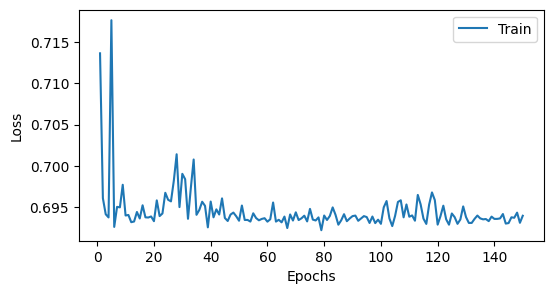

In [10]:
# plot the training loss
plt.figure(figsize=(6, 3))
plt.plot(range(1, num_epochs_alexnet+1), train_losses_alexnet, label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Testing the AlexNet model on the test data
# Set the model to evaluation mode
model_alexnet.eval()

# Turn off gradients
with torch.no_grad():
    # Make predictions
    outputs_alexnet = model_alexnet(X_test)
    # Get the maximum prediction across the rows
    _, preds_alexnet = torch.max(outputs_alexnet, 1)

# Move the predictions and labels to CPU
preds_alexnet = preds_alexnet.cpu()

# Print the classification report for AlexNet
print("AlexNet Classification Report:")
print(classification_report(y_test, preds_alexnet, target_names=class_names))

# Print the accuracy for AlexNet
an_acc = accuracy_score(y_test, preds_alexnet)
print("\nAlexNet Accuracy: {:.2f}%".format(an_acc*100))

AlexNet Classification Report:
              precision    recall  f1-score   support

     chicken       0.50      1.00      0.67        12
        duck       0.00      0.00      0.00        12

    accuracy                           0.50        24
   macro avg       0.25      0.50      0.33        24
weighted avg       0.25      0.50      0.33        24


AlexNet Accuracy: 50.00%


/Users/paulanwesha01/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/paulanwesha01/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/paulanwesha01/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

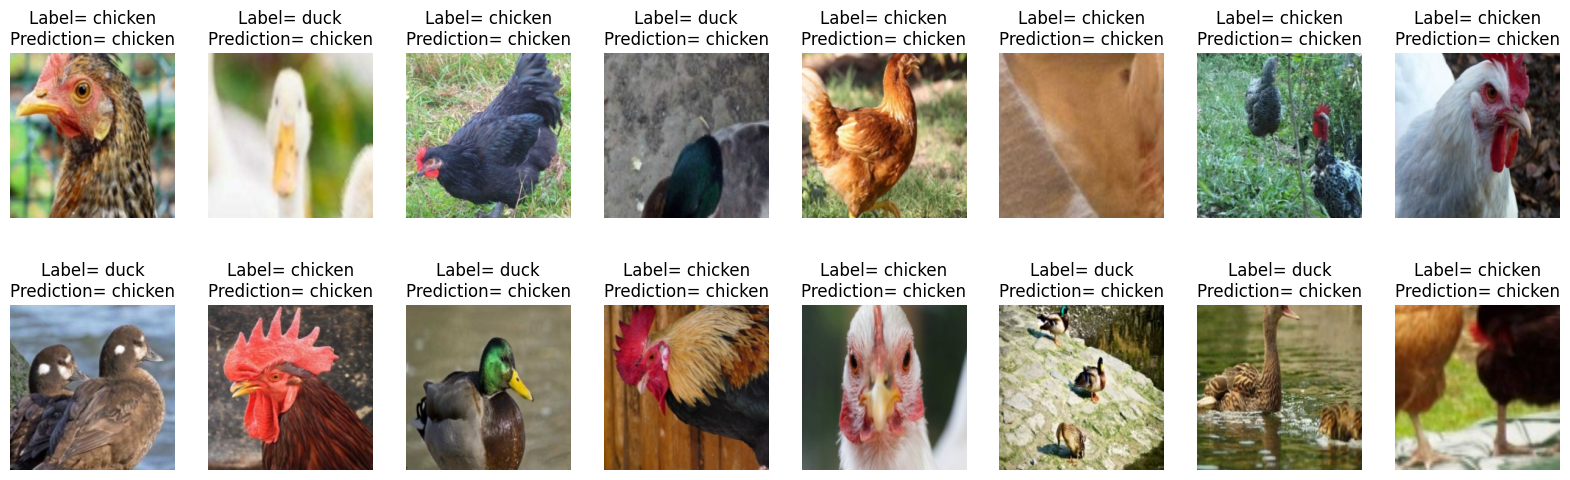

In [12]:
# visualize a few samples from the test data
plt.figure(figsize=(20, 6))

# plot images in 3 rows and 3 columns
for i in range(16):
    plt.subplot(2, 8, i+1)

    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    
    # we have multi-channel image
    # pre-precoss the image before printing
    img = np.transpose(img, (1,2,0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title("Label= {}\nPrediction= {}".format(class_names[y_test[i]], class_names[preds_alexnet[i]]))
    plt.grid(False)
    plt.axis(False)

plt.show()

## ResNet18

In [13]:
model_resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# freeze all the layers except the final FC Layer
for params in model_resnet18.parameters():
    params.requires_grad = False

# extract the input features size taken in by the last FC Layer
fc_inp_size = model_resnet18.fc.in_features

# reset the final FC Layer with new weights
model_resnet18.fc = nn.Linear(fc_inp_size, len(class_names))

In [14]:
# set the hyper-parameters
num_epochs = 150
learning_rate = 0.001

# step sizes
print_step = 5
model_save_step = 25

# define the loss function
criterion = nn.CrossEntropyLoss()

# define the optimizer
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=learning_rate)

# define the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

# store the training loss
train_losses = []

# training loop
for epoch in tqdm(range(num_epochs)):
    # set the model to training mode
    model_resnet18.train()

    # keep track of the epoch training loss
    epoch_loss = 0.0

    # loop over the training data in batches
    for inputs, labels in image_dataloaders['train']:

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model_resnet18(inputs)

        # calculate the loss
        loss = criterion(outputs, labels)

        # backward pass
        loss.backward()

        # optimize the weights
        optimizer.step()

        # update the epoch training loss
        epoch_loss += loss.item()
    
    # store the mean epoch loss
    train_losses.append(epoch_loss/len(image_dataloaders['train']))


    # print training information every `print_step` epochs
    if (epoch + 1) % print_step == 0:
        print("Epoch {}/{} Training Loss: {:.4f}".format(epoch+1, num_epochs, train_losses[-1]))
    
    # save the model weights every `model_save_size` epochs
    if (epoch + 1) % model_save_step == 0:
        torch.save(model_resnet18.state_dict(), os.path.join('models', 'resnet18_epoch{}.pth'.format(epoch+1)))
        print("Saved model weights at models/resnet18_epoch{}.pth".format(epoch+1))

  3%|▎         | 5/150 [01:25<40:07, 16.61s/it]

Epoch 5/150 Training Loss: 0.2356


  7%|▋         | 10/150 [02:45<37:43, 16.16s/it]

Epoch 10/150 Training Loss: 0.2177


 10%|█         | 15/150 [04:06<36:26, 16.20s/it]

Epoch 15/150 Training Loss: 0.1443


 13%|█▎        | 20/150 [05:27<34:59, 16.15s/it]

Epoch 20/150 Training Loss: 0.1669


 17%|█▋        | 25/150 [06:49<33:50, 16.24s/it]

Epoch 25/150 Training Loss: 0.1703
Saved model weights at models/resnet18_epoch25.pth


 20%|██        | 30/150 [08:13<34:41, 17.35s/it]

Epoch 30/150 Training Loss: 0.1206


 23%|██▎       | 35/150 [09:35<31:22, 16.37s/it]

Epoch 35/150 Training Loss: 0.1290


 27%|██▋       | 40/150 [11:06<33:50, 18.46s/it]

Epoch 40/150 Training Loss: 0.1501


 30%|███       | 45/150 [12:28<29:14, 16.71s/it]

Epoch 45/150 Training Loss: 0.1227


 33%|███▎      | 50/150 [13:50<27:30, 16.51s/it]

Epoch 50/150 Training Loss: 0.1585
Saved model weights at models/resnet18_epoch50.pth


 37%|███▋      | 55/150 [15:13<26:09, 16.52s/it]

Epoch 55/150 Training Loss: 0.1123


 40%|████      | 60/150 [16:33<24:17, 16.20s/it]

Epoch 60/150 Training Loss: 0.1276


 43%|████▎     | 65/150 [17:54<22:47, 16.09s/it]

Epoch 65/150 Training Loss: 0.1095


 47%|████▋     | 70/150 [19:14<21:21, 16.02s/it]

Epoch 70/150 Training Loss: 0.1330


 50%|█████     | 75/150 [20:33<19:48, 15.85s/it]

Epoch 75/150 Training Loss: 0.0752
Saved model weights at models/resnet18_epoch75.pth


 53%|█████▎    | 80/150 [21:53<18:28, 15.83s/it]

Epoch 80/150 Training Loss: 0.1477


 57%|█████▋    | 85/150 [23:12<17:05, 15.78s/it]

Epoch 85/150 Training Loss: 0.1176


 60%|██████    | 90/150 [24:31<15:45, 15.77s/it]

Epoch 90/150 Training Loss: 0.1812


 63%|██████▎   | 95/150 [25:52<14:42, 16.05s/it]

Epoch 95/150 Training Loss: 0.0982


 67%|██████▋   | 100/150 [27:11<13:12, 15.86s/it]

Epoch 100/150 Training Loss: 0.1064
Saved model weights at models/resnet18_epoch100.pth


 70%|███████   | 105/150 [28:30<11:50, 15.78s/it]

Epoch 105/150 Training Loss: 0.1050


 73%|███████▎  | 110/150 [30:09<11:50, 17.77s/it]

Epoch 110/150 Training Loss: 0.1173


 77%|███████▋  | 115/150 [31:31<09:39, 16.57s/it]

Epoch 115/150 Training Loss: 0.0710


 80%|████████  | 120/150 [32:53<08:21, 16.72s/it]

Epoch 120/150 Training Loss: 0.0877


 83%|████████▎ | 125/150 [34:20<07:12, 17.29s/it]

Epoch 125/150 Training Loss: 0.0904
Saved model weights at models/resnet18_epoch125.pth


 87%|████████▋ | 130/150 [35:54<06:21, 19.09s/it]

Epoch 130/150 Training Loss: 0.1083


 90%|█████████ | 135/150 [37:20<04:21, 17.44s/it]

Epoch 135/150 Training Loss: 0.0764


 93%|█████████▎| 140/150 [38:44<02:48, 16.83s/it]

Epoch 140/150 Training Loss: 0.1806


 97%|█████████▋| 145/150 [40:17<01:31, 18.27s/it]

Epoch 145/150 Training Loss: 0.0816


100%|██████████| 150/150 [41:43<00:00, 16.69s/it]

Epoch 150/150 Training Loss: 0.1492
Saved model weights at models/resnet18_epoch150.pth


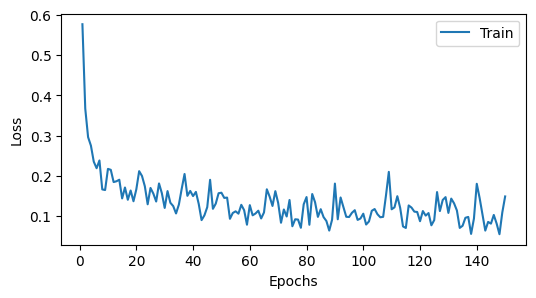

In [15]:
# plot the training loss
plt.figure(figsize=(6, 3))
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# testing the model on the test data
# set the model to evaluation mode
model_resnet18.eval()

# turn off gradients
with torch.no_grad():
    # make predictions
    outputs = model_resnet18(X_test)
    # get the maximum prediction across the rows
    _, preds = torch.max(outputs, 1)

# move the predictions and labels to cpu
preds = preds.cpu()
y_test = y_test.cpu()

# print the classification report
print(classification_report(y_test, preds, target_names=class_names))

# print the accuracy
rn18_acc = accuracy_score(y_test, preds)
print("\nAccuracy: {:.2f}%".format(rn18_acc*100))

              precision    recall  f1-score   support

     chicken       1.00      0.83      0.91        12
        duck       0.86      1.00      0.92        12

    accuracy                           0.92        24
   macro avg       0.93      0.92      0.92        24
weighted avg       0.93      0.92      0.92        24


Accuracy: 91.67%


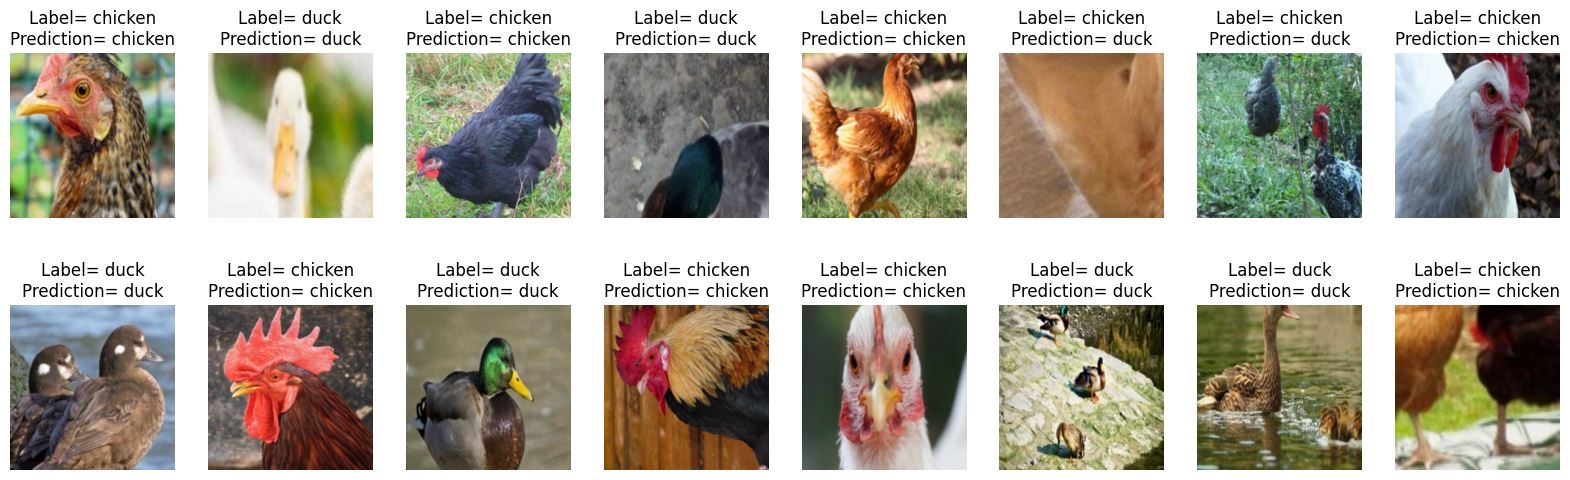

In [17]:
# visualize a few samples from the test data
plt.figure(figsize=(20, 6))

# plot images in 3 rows and 3 columns
for i in range(16):
    plt.subplot(2, 8, i+1)
    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    
    # we have multi-channel image
    # pre-precoss the image before printing
    img = np.transpose(img, (1,2,0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title("Label= {}\nPrediction= {}".format(class_names[y_test[i]], class_names[preds[i]]))
    plt.grid(False)
    plt.axis(False)

plt.show()

## ResNet50

In [18]:
# Load ResNet50 model
model_resnet50 = models.resnet50(pretrained=True)

# Freeze all the layers except the final FC Layer
for params in model_resnet50.parameters():
    params.requires_grad = False

# Extract the input features size taken in by the last FC Layer
fc_inp_size_resnet50 = model_resnet50.fc.in_features

# Reset the final FC Layer with new weights
model_resnet50.fc = nn.Linear(fc_inp_size_resnet50, len(class_names))

/Users/paulanwesha01/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/paulanwesha01/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# Set the hyper-parameters
num_epochs_resnet50 = 150
learning_rate_resnet50 = 0.001

# Define the optimizer
optimizer_resnet50 = torch.optim.Adam(model_resnet50.parameters(), lr=learning_rate_resnet50)

# Define the learning rate scheduler
lr_scheduler_resnet50 = torch.optim.lr_scheduler.StepLR(optimizer_resnet50, step_size=8, gamma=0.1)

# Store the training loss
train_losses_resnet50 = []

# Training loop for ResNet50
for epoch in tqdm(range(num_epochs_resnet50)):
    # Set the model to training mode
    model_resnet50.train()

    # Keep track of the epoch training loss
    epoch_loss_resnet50 = 0.0

    # Loop over the training data in batches
    for inputs, labels in image_dataloaders['train']:
        # Zero the parameter gradients
        optimizer_resnet50.zero_grad()

        # Forward pass
        outputs = model_resnet50(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer_resnet50.step()

        # Update the epoch training loss
        epoch_loss_resnet50 += loss.item()
    
    # Store the mean epoch loss
    train_losses_resnet50.append(epoch_loss_resnet50/len(image_dataloaders['train']))

    # Print training information every `print_step` epochs
    if (epoch + 1) % print_step == 0:
        print("Epoch {}/{} Training Loss (ResNet50): {:.4f}".format(epoch+1, num_epochs_resnet50, train_losses_resnet50[-1]))
    
    # Save the model weights every `model_save_size` epochs
    if (epoch + 1) % model_save_step == 0:
        torch.save(model_resnet50.state_dict(), os.path.join('models', 'resnet50_epoch{}.pth'.format(epoch+1)))
        print("Saved model weights at models/resnet50_epoch{}.pth".format(epoch+1))

  3%|▎         | 5/150 [04:12<2:01:40, 50.35s/it]

Epoch 5/150 Training Loss (ResNet50): 0.1405


  7%|▋         | 10/150 [08:34<1:52:36, 48.26s/it]

Epoch 10/150 Training Loss (ResNet50): 0.1932


 10%|█         | 15/150 [12:26<1:47:07, 47.61s/it]

Epoch 15/150 Training Loss (ResNet50): 0.1094


 13%|█▎        | 20/150 [17:01<1:56:17, 53.68s/it]

Epoch 20/150 Training Loss (ResNet50): 0.0962


 16%|█▌        | 24/150 [19:55<1:36:06, 45.77s/it]

Epoch 25/150 Training Loss (ResNet50): 0.0604


 17%|█▋        | 25/150 [20:42<1:36:04, 46.12s/it]

Saved model weights at models/resnet50_epoch25.pth


 20%|██        | 30/150 [24:44<1:34:07, 47.07s/it]

Epoch 30/150 Training Loss (ResNet50): 0.1841


 23%|██▎       | 35/150 [28:38<1:29:48, 46.86s/it]

Epoch 35/150 Training Loss (ResNet50): 0.1522


 27%|██▋       | 40/150 [32:41<1:26:41, 47.28s/it]

Epoch 40/150 Training Loss (ResNet50): 0.0937


 30%|███       | 45/150 [36:48<1:25:36, 48.92s/it]

Epoch 45/150 Training Loss (ResNet50): 0.1476


 33%|███▎      | 49/150 [39:53<1:19:06, 46.99s/it]

Epoch 50/150 Training Loss (ResNet50): 0.1341


 33%|███▎      | 50/150 [40:48<1:22:02, 49.23s/it]

Saved model weights at models/resnet50_epoch50.pth


 37%|███▋      | 55/150 [46:03<1:37:43, 61.72s/it]

Epoch 55/150 Training Loss (ResNet50): 0.0973


 40%|████      | 60/150 [50:31<1:19:32, 53.02s/it]

Epoch 60/150 Training Loss (ResNet50): 0.1051


 43%|████▎     | 65/150 [54:20<1:04:44, 45.70s/it]

Epoch 65/150 Training Loss (ResNet50): 0.1479


 47%|████▋     | 70/150 [58:24<1:02:47, 47.09s/it]

Epoch 70/150 Training Loss (ResNet50): 0.0587


 49%|████▉     | 74/150 [1:01:17<55:42, 43.98s/it]

Epoch 75/150 Training Loss (ResNet50): 0.0880


 50%|█████     | 75/150 [1:01:59<54:07, 43.30s/it]

Saved model weights at models/resnet50_epoch75.pth


 53%|█████▎    | 80/150 [1:06:30<59:01, 50.59s/it]  

Epoch 80/150 Training Loss (ResNet50): 0.0806


 57%|█████▋    | 85/150 [1:11:10<1:03:10, 58.31s/it]

Epoch 85/150 Training Loss (ResNet50): 0.0316


 60%|██████    | 90/150 [1:15:41<56:58, 56.98s/it]  

Epoch 90/150 Training Loss (ResNet50): 0.1372


 63%|██████▎   | 95/150 [1:20:04<45:40, 49.82s/it]

Epoch 95/150 Training Loss (ResNet50): 0.0729


 66%|██████▌   | 99/150 [1:23:08<41:14, 48.52s/it]

Epoch 100/150 Training Loss (ResNet50): 0.1065


 67%|██████▋   | 100/150 [1:24:01<41:19, 49.59s/it]

Saved model weights at models/resnet50_epoch100.pth


 70%|███████   | 105/150 [1:28:37<41:42, 55.61s/it]

Epoch 105/150 Training Loss (ResNet50): 0.0651


 73%|███████▎  | 110/150 [1:32:55<34:18, 51.47s/it]

Epoch 110/150 Training Loss (ResNet50): 0.0540


 77%|███████▋  | 115/150 [1:36:52<27:52, 47.79s/it]

Epoch 115/150 Training Loss (ResNet50): 0.1428


 80%|████████  | 120/150 [1:41:04<25:33, 51.12s/it]

Epoch 120/150 Training Loss (ResNet50): 0.1239


 83%|████████▎ | 124/150 [1:45:01<25:04, 57.88s/it]

Epoch 125/150 Training Loss (ResNet50): 0.0964


 83%|████████▎ | 125/150 [1:45:59<24:06, 57.87s/it]

Saved model weights at models/resnet50_epoch125.pth


 87%|████████▋ | 130/150 [1:51:02<20:19, 60.98s/it]

Epoch 130/150 Training Loss (ResNet50): 0.1008


 90%|█████████ | 135/150 [1:55:53<13:53, 55.59s/it]

Epoch 135/150 Training Loss (ResNet50): 0.0800


 93%|█████████▎| 140/150 [2:00:03<08:33, 51.40s/it]

Epoch 140/150 Training Loss (ResNet50): 0.0287


 97%|█████████▋| 145/150 [2:04:13<04:03, 48.69s/it]

Epoch 145/150 Training Loss (ResNet50): 0.0571


 99%|█████████▉| 149/150 [2:07:44<00:51, 51.14s/it]

Epoch 150/150 Training Loss (ResNet50): 0.1127


100%|██████████| 150/150 [2:08:29<00:00, 51.40s/it]

Saved model weights at models/resnet50_epoch150.pth


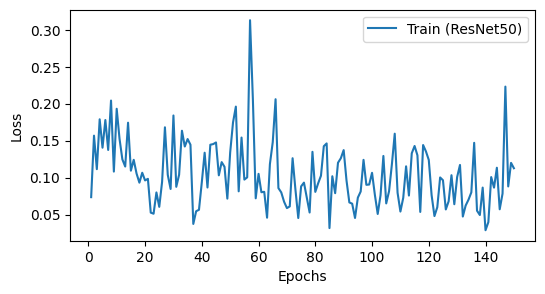

In [21]:
# Plot the training loss for ResNet50
plt.figure(figsize=(6, 3))
plt.plot(range(1, num_epochs_resnet50+1), train_losses_resnet50, label='Train (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Testing the ResNet50 model on the test data
# Set the model to evaluation mode
model_resnet50.eval()

# Turn off gradients
with torch.no_grad():
    # Make predictions
    outputs_resnet50 = model_resnet50(X_test)
    
    # Get the maximum prediction across the rows
    _, preds_resnet50 = torch.max(outputs_resnet50, 1)

# Move the predictions and labels to CPU
preds_resnet50 = preds_resnet50.cpu()

# Print the classification report for ResNet50
print("ResNet50 Classification Report:")
print(classification_report(y_test, preds_resnet50, target_names=class_names))

# Print the accuracy for ResNet50
rn50_acc = accuracy_score(y_test, preds_resnet50)
print("\nResNet50 Accuracy: {:.2f}%".format(rn50_acc*100))

ResNet50 Classification Report:
              precision    recall  f1-score   support

     chicken       1.00      1.00      1.00        12
        duck       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24


ResNet50 Accuracy: 100.00%


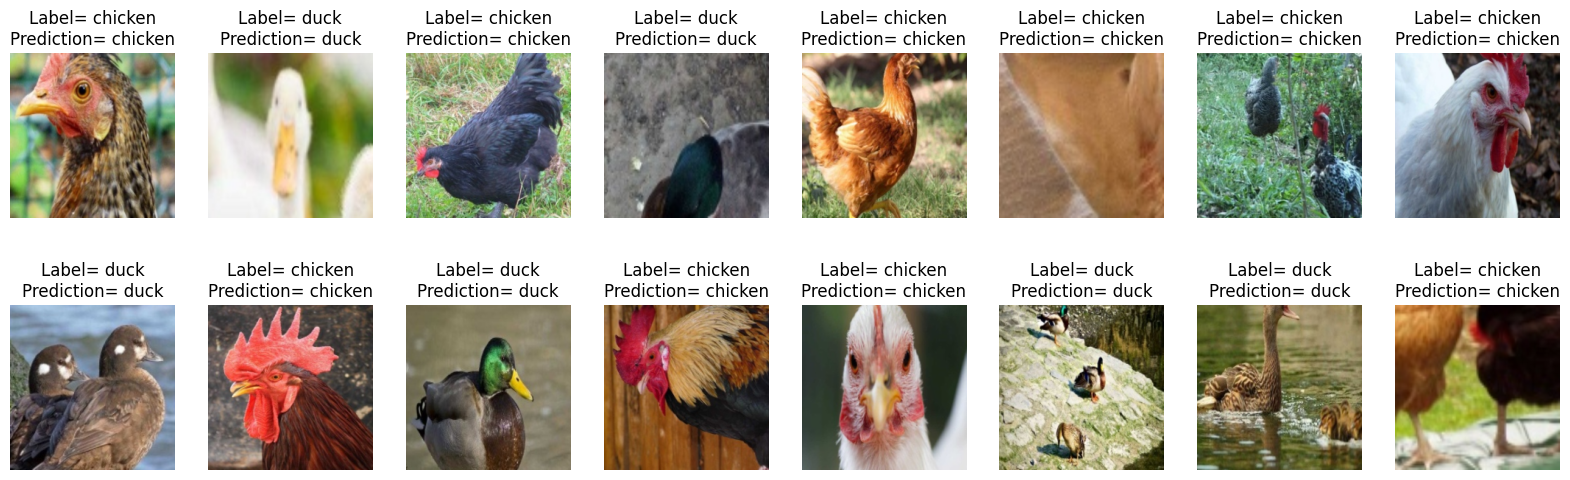

In [23]:
# visualize a few samples from the test data
plt.figure(figsize=(20, 6))

# plot images in 3 rows and 3 columns
for i in range(16):
    plt.subplot(2, 8, i+1)

    # copy the image back to cpu to reshape
    img = X_test[i].cpu()
    
    # we have multi-channel image
    # pre-precoss the image before printing
    img = np.transpose(img, (1,2,0))
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title("Label= {}\nPrediction= {}".format(class_names[y_test[i]], class_names[preds_resnet50[i]]))
    plt.grid(False)
    plt.axis(False)

plt.show()

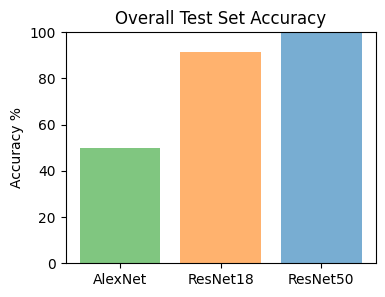

In [24]:
# Overall test set accuracy of the three models
plt.figure(figsize=(4, 3))
plt.bar(['AlexNet','ResNet18','ResNet50'], [an_acc*100,rn18_acc*100,rn50_acc*100], alpha=0.6, color=['tab:green','tab:orange','tab:blue'],)
plt.ylim(0,100)
plt.title("Overall Test Set Accuracy")
plt.ylabel("Accuracy %")
plt.show()